In [1]:
### We import the packages we need 
import gym
from gym import spaces
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
#from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import deque
import cv2
import math
import copy
import pickle
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import random
from IPython.display import clear_output


cv2.ocl.setUseOpenCL(False)

In [2]:
### Connection with google drive so we can save the results and graphs
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### This is a representation of the MDP 
env = gym.make("Taxi-v3").env
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [ ]:
### We can enconde the state composed by taxi row, taxi column, passenger index, destination index
state = env.encode(3, 1, 2, 0) # 
print("State:", state)

env.s = state
env.render()

State: 328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [ ]:
### This function evalute the policy given by the table q_table, recording average epochs and penalties ffor 100 episodes
def evalute(q_table_param): 
  '''Evaluate agent's performance after Q-learning'''
  '''@q_table_param: q_table with the policy to evaluate'''
  
  total_epochs, total_penalties = 0, 0
  episodes = 100

  for _ in range(episodes):
      state = env.reset()
      epochs, penalties, reward = 0, 0, 0
      
      done = False
      
      while (not done) and (epochs<=100):
          action = np.argmax(q_table_param[state])
          state, reward, done, info = env.step(action)

          if reward == -10:
              penalties += 1

          epochs += 1

      total_penalties += penalties
      total_epochs += epochs

  print(f"Results after {episodes} episodes:")
  print(f"Average timesteps per episode: {total_epochs / episodes}")
  print(f"Average penalties per episode: {total_penalties / episodes}")

  return total_epochs / episodes

In [ ]:
### This function apply TD Lambda to find the optimal policy for some given hyperparameters
### Since this is a control MDP we already know the optimal average epochs is 14, we stop the iteration at that point to measure performance
### This function return the iteration when the optimal is reached and the Q_table
def q_learning(alpha_param,gamma_param,epsilon_param):

  %%time
  '''Training the agent'''
  '''
  @alpha_param: this is the lambda of TD lambda 
  @gamma_param: this is the discount factor 
  @epsilon_param: this is the treshold set for exploration 
  ''' 
  q_table = np.zeros([env.observation_space.n, env.action_space.n])
  # Hyperparameters
  alpha = alpha_param
  gamma = gamma_param
  epsilon = epsilon_param

  # For plotting metrics
  all_epochs = 0
  all_penalties = []

  for i in range(1, 100001):
      state = env.reset()

      epochs, penalties, reward, = 0, 0, 0
      done = False
      
      while not done:
          if random.uniform(0, 1) < epsilon:
              action = env.action_space.sample() # Explore action space
          else:
              action = np.argmax(q_table[state]) # Exploit learned values

          next_state, reward, done, info = env.step(action) 
          
          old_value = q_table[state, action]
          next_max = np.max(q_table[next_state])
          
          new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
          q_table[state, action] = new_value

          if reward == -10:
              penalties += 1

          state = next_state
          epochs += 1

      all_epochs=all_epochs+epochs
          
      if i % 100 == 0:
          clear_output(wait=True)
          print(f"Episode: {i}")
          average=evalute(q_table)
          if average<=14: 
            break
  print("Training finished.\n")
  return (i,q_table,all_epochs)

In [ ]:
### Iterates over the hyperparameters to find the best combination 
results=pd.DataFrame()
alpha_list=[]
gamma_list=[]
epsilon_list=[]
iter_list=[]
epoch_list=[]

for i in range(1,11): 
  for j in range(1,11): 
    for k in range(1,11): 
      alpha_list.append(i)
      gamma_list.append(j)
      epsilon_list.append(k)
      var_1,var_2,var_3=q_learning(i/10,j/10,k/10)
      iter_list.append(var_1)
      epoch_list.append(var_3)

results['alpha']=alpha_list
results['gamma']=gamma_list
results['epsilon']=epsilon_list
results['iteration']=iter_list
results['epochs']=epoch_list


Episode: 100
Results after 100 episodes:
Average timesteps per episode: 13.22
Average penalties per episode: 0.0
h
Training finished.



In [ ]:
### Rescale to the true values of lambda, gamma and epsilon 
results['gamma']=results['gamma']/10
results['epsilon']=results['epsilon']/10
results['alpha']=results['alpha']/10


In [ ]:
### Save the results on a csv file for reproducibility 
results.to_csv('/content/drive/MyDrive/Classroom/21D000 - DSM Master Project 21-22 DSM T3/results_q_learning.csv')

In [16]:
results=pd.read_csv('/content/drive/MyDrive/Classroom/21D000 - DSM Master Project 21-22 DSM T3/results_q_learning.csv')

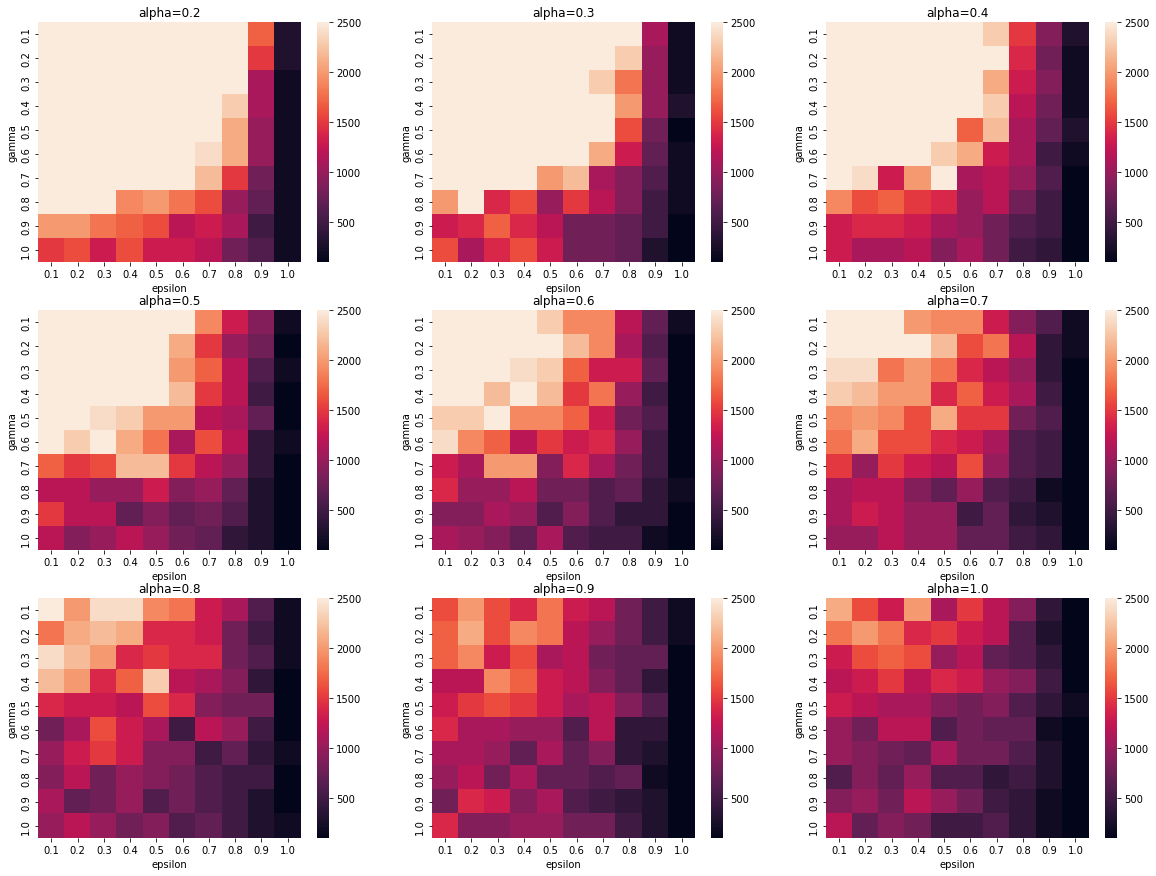

In [21]:
### Plot heatmaps with the best combination of hyperparameters
fig, axs = plt.subplots(3, 3, figsize=(20, 15), sharey=False)
cont=1
for i in range(0,3): 
  for j in range(0,3): 
    cont=cont+1
    temp=results[results['alpha']==(cont/10)]
    temp_1=temp.pivot_table(index='gamma',columns='epsilon',values='iteration',aggfunc='sum')
    axs[i][j].set_title('alpha='+str(cont/10))
    sns.heatmap(temp_1,ax=axs[i][j],vmin=100, vmax=2500)

plt.savefig('/content/drive/MyDrive/Classroom/21D000 - DSM Master Project 21-22 DSM T3/visulization/Parameters_q_learning.png', bbox_inches='tight')
plt.show()

In [19]:
results[results['epochs']==results['epochs'].min()].head()

,Unnamed: 0,alpha,gamma,epsilon,iteration,epochs
970,970,1.0,0.8,0.1,600,24919


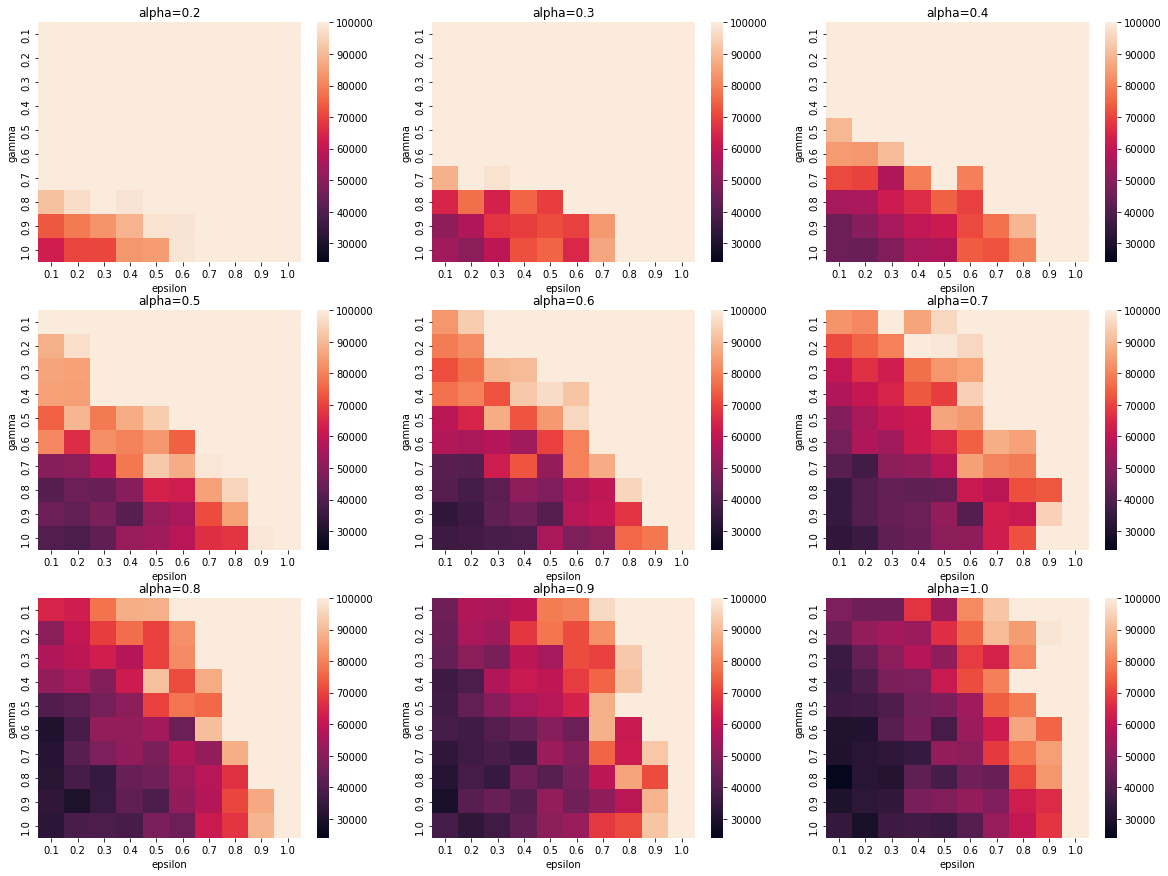

In [20]:
### Plot heatmaps with the best combination of hyperparameters
fig, axs = plt.subplots(3, 3, figsize=(20, 15), sharey=False)
cont=1
for i in range(0,3): 
  for j in range(0,3): 
    cont=cont+1
    temp=results[results['alpha']==(cont/10)]
    temp_1=temp.pivot_table(index='gamma',columns='epsilon',values='epochs',aggfunc='sum')
    axs[i][j].set_title('alpha='+str(cont/10))
    sns.heatmap(temp_1,ax=axs[i][j],vmin=24000, vmax=100000)

plt.show()

In [ ]:
### Epsilon 1 is when you take a random action everytime, in this MDP taking a random action everytime lead to know the entaire board, 
### we should compare with different levels of epsilon, in some DMPS you can only know some parts of the states and actions 

In [ ]:
### Generating the Q_Table with the optimal hyperparameters
q_table=q_learning(1,1,1)[1]

Episode: 100
Results after 100 episodes:
Average timesteps per episode: 13.54
Average penalties per episode: 0.0
h
Training finished.



In [ ]:
### Visualization of the optimal policy 
state = env.reset()
epochs, penalties, reward = 0, 0, 0

done = False

while not done:
    env.render()
    action = np.argmax(q_table[state])
    state, reward, done, info = env.step(action)

    if reward == -10:
      penalties += 1

    epochs += 1

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
|_: | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
|_: : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| :_: : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : :_: : |
| | : | : |
|Y| : |B: 